# 전체 개요
1. 대출 잔액에 가장 큰 영향을 미치는 주요 feature 탐색 과정 모델링
2. 범주형 데이터들은 word embedding과 유사하게, n차원 벡터로 전처리하여, target과의 관계성을 내포할 수 있도록 구조화
3. AutoEncoder를 활용하여 Latent space를 만들고, 축소된 차원 공간을 활용하여 XGBoostRegressor 모델링
4. 학습 과정에서는 K-fold validation 활용
5. 모델링 후에는 SHAP를 활용하여, 가장 유의미한 latent feature를 찾고, latent feature를 원본 데이터에 매핑하여 주요 feature 탐색 과정을 종료
6. 모델링 결과, 대출 잔액에 가장 큰 영향을 미치는 것은 차주의 근무지 타입과 직업 종류
7. 부도 예측 모델과 동일한 데이터셋 사용

# 데이터 전처리

In [1]:
import pandas as pd
Data_EDA = pd.read_csv('../../Data/home-credit-default-risk/application_train.csv',index_col='SK_ID_CURR')

In [2]:
import pandas as pd
import numpy as np
import pandas.api.types as ptypes

threshold = 10

cat_cols_by_cardinality = []
num_cols_by_cardinality = []

for col in Data_EDA.columns:

    # 고유값 개수 확인
    unique_count = Data_EDA[col].nunique()
    
    if 'flag' in col.lower():
        cat_cols_by_cardinality.append(col)
    elif 'amt' in col.lower():
        num_cols_by_cardinality.append(col)

    # 실수형/정수형이면 일단 수치형으로 분류하되, 
    # 만약 유니크 값이 작은 범주 느낌이라면 cat_cols_by_cardinality 로 옮길 수도 있음
    elif ptypes.is_numeric_dtype(Data_EDA[col]):
        if unique_count < threshold:
            cat_cols_by_cardinality.append(col)
        else:
            num_cols_by_cardinality.append(col)
    else:
        # 문자인 경우 범주형으로 분류
        cat_cols_by_cardinality.append(col)

print("범주형(유니크값 < 10):", cat_cols_by_cardinality)
print("수치형(유니크값 >= 10):", num_cols_by_cardinality)


범주형(유니크값 < 10): ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16

## 결측치도 의미가 있을 수 있으므로, 보간하지 않고, MISSING으로 처리

In [ ]:
for c in cat_cols_by_cardinality:
    Data_EDA[c] = Data_EDA[c].fillna("MISSING")

## 범주형 정보 레이블 인코딩

In [3]:
# 범주형 컬럼 List에서 Target 컬럼을 제외함
cat_cols_by_cardinality_less_target = [x for x in cat_cols_by_cardinality if x != 'AMT_CREDIT']

print(cat_cols_by_cardinality_less_target) 

['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMEN

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# LabelEncoder를 보관할 딕셔너리 (각 컬럼별로 학습된 encoder를 저장)
Data_EDA_labeled = Data_EDA.copy()
encoders = {}
# 각 범주형 컬럼에 대해 LabelEncoder로 변환
for col in cat_cols_by_cardinality_less_target:
    le = LabelEncoder()
    Data_EDA_labeled[col] = le.fit_transform(Data_EDA[col])
    encoders[col] = le

## 수치형 데이터 스케일링
- 이 노트북으로는 KNNImputer를 활용한 보간법이 안돌아가서 그냥 중위값으로 대체하는 것을 대안으로 생각

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler

num_data = Data_EDA[num_cols_by_cardinality].values

imp = IterativeImputer(max_iter=10, random_state=42) #하이퍼 파라미터에 대하여 추가적으로 시험해볼 것
num_data_mice = imp.fit_transform(num_data)

Data_mice = Data_EDA_labeled.copy()
Data_mice[num_cols_by_cardinality] = num_data_mice

scaler = RobustScaler()

Data_EDA_scaled_mice = Data_mice.copy()
Data_EDA_scaled_mice[num_cols_by_cardinality] = scaler.fit_transform(Data_mice[num_cols_by_cardinality])

# 주요 변수 찾기 모델링

In [11]:
# 필요 라이브러리
import pandas as pd
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten
import xgboost as xgb
import shap
import optuna

# 데이터 로드 (예시)
Data_EDA = pd.read_csv('../../Data/home-credit-default-risk/application_train.csv',index_col='SK_ID_CURR')

# 타겟 정의
y = Data_EDA['AMT_CREDIT']
X = Data_EDA.drop(columns=['AMT_CREDIT'])

# 범주형/수치형 컬럼 정의
threshold = 10

categorical_cols = []
numeric_cols = []

for col in X.columns:

    # 고유값 개수 확인
    unique_count = X[col].nunique()
    
    if 'flag' in col.lower():
        categorical_cols.append(col)
    elif 'amt' in col.lower():
        numeric_cols.append(col)

    # 실수형/정수형이면 일단 수치형으로 분류하되, 
    # 만약 유니크 값이 작은 범주 느낌이라면 cat_cols_by_cardinality 로 옮길 수도 있음
    elif ptypes.is_numeric_dtype(X[col]):
        if unique_count < threshold:
            categorical_cols.append(col)
        else:
            numeric_cols.append(col)
    else:
        # 문자인 경우 범주형으로 분류
        categorical_cols.append(col)

print("범주형(유니크값 < 10):", categorical_cols)
print("수치형(유니크값 >= 10):", numeric_cols)

# 범주형 데이터 임베딩 전처리
embedded_inputs = []
embedding_layers = []

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    input_dim = X[col].nunique()
    output_dim = max(1,min(50, input_dim // 2))

    input_layer = Input(shape=(1,), name=f'{col}_input')
    embedding_layer = Embedding(input_dim=input_dim + 1, output_dim=output_dim, name=f'{col}_emb')(input_layer)
    embedding_layer = Flatten()(embedding_layer)

    embedded_inputs.append(input_layer)
    embedding_layers.append(embedding_layer)

# 수치형 데이터 결측치 처리
imputer = IterativeImputer(random_state=0)
X_numeric_imputed = pd.DataFrame(imputer.fit_transform(X[numeric_cols]), columns=numeric_cols)

# Robust 스케일링
scaler = RobustScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_imputed)

# 수치형 입력층
numeric_input = Input(shape=(len(numeric_cols),), name='numeric_input')
embedded_inputs.append(numeric_input)


범주형(유니크값 < 10): ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16

In [14]:
print(embedded_inputs)
print(embedding_layers)
print(embedded_inputs)


[<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=TARGET_input>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=NAME_CONTRACT_TYPE_input>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=CODE_GENDER_input>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=FLAG_OWN_CAR_input>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=FLAG_OWN_REALTY_input>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=NAME_TYPE_SUITE_input>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=NAME_INCOME_TYPE_input>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=NAME_EDUCATION_TYPE_input>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=NAME_FAMILY_STATUS_input>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=NAME_HOUSING_TYPE_input>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=FLAG_MOBIL_input>, <KerasTensor shape=(None, 1), dtype=flo

In [35]:
# 모든 입력 병합
x = Concatenate()(embedding_layers + [numeric_input])
print(x)

<KerasTensor shape=(None, 178), dtype=float32, sparse=False, name=keras_tensor_334>


In [36]:
encoder_layer = Dense(64, activation='relu')(x)
latent = Dense(20, activation='relu', name='latent_space')(encoder_layer)

# Decoder
decoder_layer = Dense(64, activation='relu')(latent)
output = Dense(x.shape[1], activation='linear')(decoder_layer)

# Autoencoder 정의
autoencoder = Model(inputs=embedded_inputs, outputs=output)
autoencoder.compile(optimizer='adam', loss='mse')

In [37]:
# Embedding 부분만 별도의 모델을 통해 미리 계산
embedding_model = Model(inputs=embedded_inputs[:-1], outputs=Concatenate()(embedding_layers))
X_embedded = embedding_model.predict([X[col].values.reshape(-1,1) for col in categorical_cols])

# 수치형 데이터와 임베딩 벡터 합침
X_autoencoder_input = np.concatenate([X_embedded, X_numeric_scaled], axis=1)

# 최종 autoencoder 학습
autoencoder.fit(
    [X[col].values.reshape(-1,1) for col in categorical_cols] + [X_numeric_scaled],
    X_autoencoder_input,  # 입력과 동일한 출력 데이터로 설정
    epochs=50, batch_size=32, validation_split=0.2
)


9610/9610 ━━━━━━━━━━━━━━━━━━━━ 70s 7ms/step
Epoch 1/50
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 86s 9ms/step - loss: 15.4198 - val_loss: 0.9068
Epoch 2/50
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 66s 9ms/step - loss: 1.6342 - val_loss: 0.8005
Epoch 3/50
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 64s 8ms/step - loss: 1.1325 - val_loss: 0.7198
Epoch 4/50
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 62s 8ms/step - loss: 0.9647 - val_loss: 0.8361
Epoch 5/50
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 63s 8ms/step - loss: 0.8736 - val_loss: 0.9621
Epoch 6/50
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - loss: 0.9170 - val_loss: 0.3541
Epoch 7/50
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 64s 8ms/step - loss: 0.7269 - val_loss: 5.3502
Epoch 8/50
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 62s 8ms/step - loss: 0.9385 - val_loss: 0.6178
Epoch 9/50
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 63s 8ms/step - loss: 0.7187 - val_loss: 1.0284
Epoch 10/50
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 64s 8ms/step - loss: 0.7399 - val_loss: 0.4324
Epoch 11/50
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 

In [38]:
encoder_model = Model(inputs=embedded_inputs, outputs=latent)
X_encoded = encoder_model.predict([X[col].values.reshape(-1,1) for col in categorical_cols] + [X_numeric_scaled])


9610/9610 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step


[I 2025-03-14 19:23:18,428] A new study created in memory with name: no-name-4c87833a-d0b8-4c38-8b66-4862c2806a8b
[I 2025-03-14 19:29:52,650] Trial 0 finished with value: 255846.6028000422 and parameters: {'n_estimators': 3013, 'max_depth': 7, 'learning_rate': 0.025643097123188036, 'colsample_bytree': 0.6703866371820626, 'gamma': 0.8726081979352812, 'min_child_weight': 1}. Best is trial 0 with value: 255846.6028000422.
[I 2025-03-14 19:36:33,261] Trial 1 finished with value: 258864.0469162451 and parameters: {'n_estimators': 3002, 'max_depth': 7, 'learning_rate': 0.015477116153668164, 'colsample_bytree': 0.6023759594207223, 'gamma': 0.2995676708234901, 'min_child_weight': 7}. Best is trial 0 with value: 255846.6028000422.
[I 2025-03-14 19:41:28,003] Trial 2 finished with value: 258169.6213361489 and parameters: {'n_estimators': 2516, 'max_depth': 6, 'learning_rate': 0.029562417999080645, 'colsample_bytree': 0.6000199307083218, 'gamma': 2.733316039720235, 'min_child_weight': 8}. Best is

Best parameters: {'n_estimators': 3461, 'max_depth': 6, 'learning_rate': 0.04926174252544026, 'colsample_bytree': 0.7284155151159677, 'gamma': 4.417283143182851, 'min_child_weight': 1}
Generalized Test RMSE: 252839.49172262763


100%|===================| 61502/61503 [631:21<00:00]         

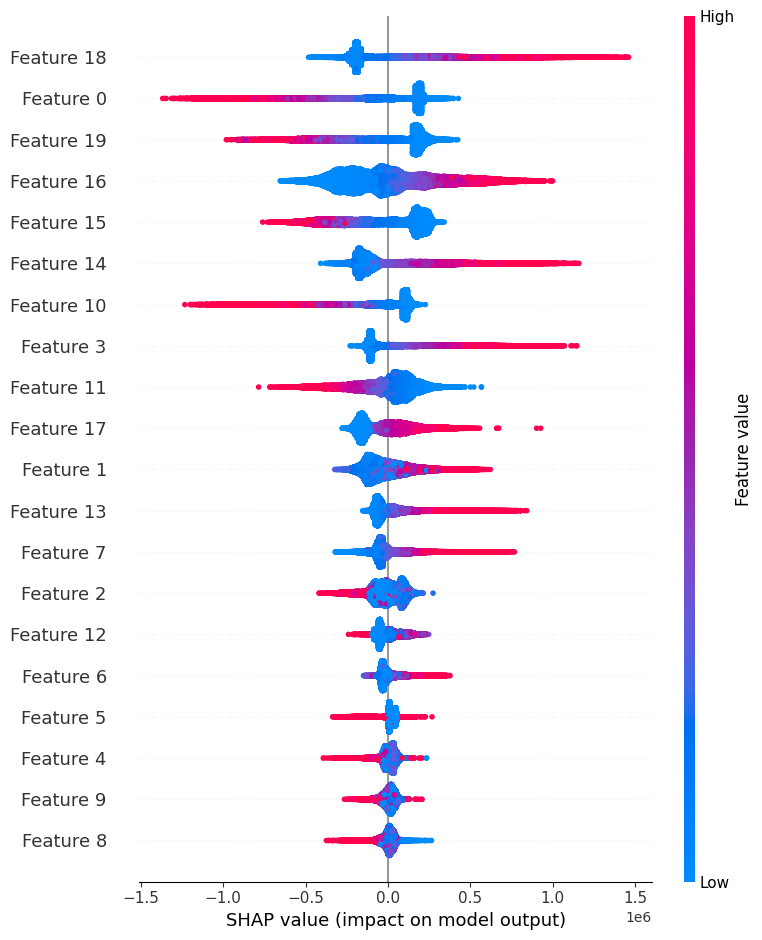

가장 영향력 있는 latent variable: 18


IndexError: list index out of range

In [45]:

# (1) 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# (2) Optuna 목적 함수
def objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1500, 3500),
        'max_depth': trial.suggest_int('max_depth', 6, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # K-Fold 정의
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # XGBoost 모델 훈련
        model = xgb.XGBRegressor(**params)
        model.fit(X_fold_train, y_fold_train,
                  eval_set=[(X_fold_val, y_fold_val)],
                  
                  verbose=False)

        # 예측 및 RMSE 계산
        preds = model.predict(X_fold_val)
        fold_rmse = np.sqrt(mean_squared_error(y_fold_val, preds))
        rmses.append(fold_rmse)

    return np.mean(rmses)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best parameters:", best_params)

# 최적 파라미터로 모델 재학습
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# 테스트 데이터로 일반화된 성능 평가
y_pred_test = best_model.predict(X_test)
print("Generalized Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

# SHAP 분석
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# 가장 영향력 높은 latent 변수 찾기
shap_sum = np.abs(shap_values.values).mean(axis=0)
most_important_latent = np.argmax(shap_sum)
print("가장 영향력 있는 latent variable:", most_important_latent)


In [50]:
encoder_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ TARGET_input (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ NAME_CONTRACT_TYPE_input      │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ CODE_GENDER_input             │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FLAG_OWN_CAR_input            │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FLAG_OWN_REALTY_input         │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ NAME_TYPE_SUITE_input         │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ NAME_INCOME_TYPE_input        │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ NAME_EDUCATION_TYPE_input     │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ NAME_FAMILY_STATUS_input      │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ NAME_HOUSING_TYPE_input       │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FLAG_MOBIL_input (InputLayer) │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FLAG_EMP_PHONE_input          │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 15,034 (58.73 KB)

 Trainable params: 15,034 (58.73 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# 수정 코드: 'latent_space' 레이어의 가중치 사용
latent_variable_weights = encoder_model.get_layer("latent_space").get_weights()[0]
latent_to_original = pd.DataFrame(latent_variable_weights,
                                  columns=[f"latent_var_{i}" for i in range(latent_variable_weights.shape[1])])

important_vars = latent_to_original.iloc[:, most_important_latent].abs().sort_values(ascending=False).head(5)
print("영향력이 가장 큰 원본 변수:")
print(important_vars)

영향력이 가장 큰 원본 변수:
53    0.393833
59    0.289085
33    0.286025
63    0.270491
54    0.214586
Name: latent_var_18, dtype: float32


인덱스 매핑:
전체 concatenated 벡터의 차원은 178이며, 각 부분은 다음과 같이 배정되어 있습니다.

예를 들어, flatten_104부터 flatten_119까지는 TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL 순으로 1~1 혹은 4, 2, 3 차원 등으로 배정됩니다.

flatten_120 (OCCUPATION_TYPE_emb)은 9차원, flatten_121와 flatten_122는 각각 1차원,flatten_123는 3차원, …
flatten_130 (ORGANIZATION_TYPE_emb)은 29차원으로 구성되어 있으며, 이 부분은 concatenated 벡터의 인덱스 47부터 75까지를 차지합니다.

33번은 occupation type을 의미
